In [2]:
import numpy as np
import Levenshtein, ast, dataIO, VBGP
from sklearn import cross_validation, linear_model, preprocessing, utils
reload(dataIO)

def error_rate(a, b):
    msd = Levenshtein.distance(a,b)
    
    return 100.0*msd/max(len(a), len(b))

def learn_offset(points, targets):
    regr = linear_model.LinearRegression()
    regr.fit(points, targets)
    
    return regr


postures = {"left_hand":["4", "8", "11"], "right_hand":["1", "7", "10"], 
            "index_finger":["3", "5", "12"], "two_hand":["2", "6", "9"]}
                
userId = 14

keys = postures.keys()
locations = []
bod = []
targets_x = []
targets_y = []
y = []

posture = 0
for key in keys:
    filenos = postures[key]
    if key == "two_hand":
        a, b, c, d, e, f = dataIO.process_twohand(userId, posture)
        posture += 2
    else:
        a, b, c, d, e, f = dataIO.process_posture(userId, filenos, posture)
        posture += 1

    locations += a
    bod += b
    targets_x += c 
    targets_y += d 
    y += e

locations = np.array(locations)
bod = np.array(bod)
targets_x = np.array(targets_x)
targets_y = np.array(targets_y)
y = np.array(y)

locations, bod, targets_x, targets_y, y = utils.shuffle(locations, bod, targets_x, targets_y, y)
locations = np.concatenate((locations, locations**2),1)

scaler = preprocessing.StandardScaler().fit(bod)  
bod_scaled = scaler.transform(bod)

thetas = np.array([[1 for x in range(24)], [0.1 for x in range(24)], [0.01 for x in range(24)],
     [0.001 for x in range(24)],[10 for x in range(24)]])

gp = VBGP.VBGP()
gp.fit(bod_scaled, y, thetas[0], nos_its=50, thresh=0.1)
gp.optimize(thetas, nos_its=50, thresh=0.1)

print ("Best gamma: %.3f" %gp.Theta[0][0])

regr_x = [] 
regr_y = []

for i in range(5):
    index = np.where(y==i)[0]
    regr_x.append(learn_offset(locations[index], targets_x[index]))
    regr_y.append(learn_offset(locations[index], targets_y[index])) 

with open("../../Loggingapp/dataset.txt") as f:
    pool = f.read().splitlines()

pool = sorted(pool, key=len, reverse=True)

req_sentences = []
typed_phys = []
pred_phys = []
typed_virtual=[]
pred_virtual = []

for i in range(13, 25):
    column_index = 0
    if i in [15, 17, 21]:
        column_index = 1

    with open("../../data/"+str(userId)+"_"+str(i)+"up.txt") as f:
        lines = f.read().splitlines()
        touches = map(lambda x: x.split('\t'), lines[1:])

    touches = np.array(touches)
    locations = []
    req_string = ''
    bods = []

    for touch in touches:
        req_string = req_string + ''.join(touch[column_index]) 
        bod = dataIO.createlist(touch[column_index+4])

        if dataIO.contains_spikes(bod):
            continue

        bods.append(bod)
        locations.append(ast.literal_eval(touch[column_index+2]))

    bods = np.array(bods)
    locations=np.array(locations)

    for sentence in pool:
        if len(req_string)==0:
            break

        index = req_string.find(sentence)
        if index!=-1:
            req_sentences.append(sentence)
            typed_locations = np.array(locations[index:index+len(sentence)])
            typed_bod = np.array(bods[index:index+len(sentence)])

            req_string = req_string[:index]+req_string[index+len(sentence):]
            locations = np.delete(locations, np.s_[index:index+len(sentence)], 0)
            bods = np.delete(bods, np.s_[index:index+len(sentence)], 0)

            bod_data = scaler.transform(typed_bod)
            pred = gp.predict(bod_data)
            vectors = np.concatenate((typed_locations, typed_locations **2),1)

            pred_x = np.zeros(len(vectors))
            pred_y = np.zeros(len(vectors))
            for i in range(len(vectors)):
                for j in range(5):
                    pred_x[i] += pred[i][j]*regr_x[j].predict(vectors[i])
                    pred_y[i] += pred[i][j]*regr_y[j].predict(vectors[i])

            new_points = typed_locations + np.dstack((pred_x, pred_y))[0]
            typed_virtual.append(dataIO.typed_virt(typed_locations))
            pred_virtual.append(dataIO.typed_virt(new_points))
            
            typed_phys.append(dataIO.typed_phys(typed_locations))
            pred_phys.append(dataIO.typed_phys(new_points))

error_typed = np.zeros((len(req_sentences), 7))
error_pred = np.zeros((len(req_sentences), 7))
phys_typed = np.zeros(len(req_sentences))
phys_pred = np.zeros(len(req_sentences))
for i in range(len(req_sentences)):    
    req_sentence = req_sentences[i]
    for j in range(7):
        typed_sentence = typed_virtual[i][j]
        pred_sentence = pred_virtual[i][j]
        error_typed[i][j] = error_rate(req_sentence, typed_sentence)
        error_pred[i][j] = error_rate(req_sentence, pred_sentence)
    
    phys_typed[i] = error_rate(req_sentence, typed_phys[i])
    phys_pred[i] = error_rate(req_sentence, pred_phys[i])

print
print ("Physical button error rate before model: %.2f%%" %np.mean(phys_typed))    
print ("Physical button error rate after model: %.2f%%" %np.mean(phys_pred))      

Best gamma: 0.100

Physical button error rate before model: 18.82%
Physical button error rate after model: 15.79%


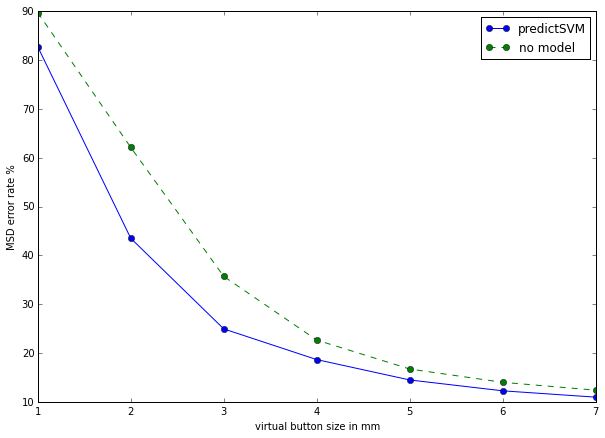

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 7))

before = np.mean(error_typed, 0)
after = np.mean(error_pred, 0)

plt.errorbar(range(1,8), after, marker="o", label = "predictSVM")
plt.errorbar(range(1,8), before, linestyle="--", marker="o", label="no model")

plt.legend(loc='best')
plt.xlabel('virtual button size in mm')
plt.ylabel('MSD error rate %')
#plt.savefig('/home/dimitar/Desktop/Latex/L5Project/mpaper/img/pred_post13.png', bbox_inches='tight', dpi=400)
plt.show()